# Resizing and padding

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
import os
from os.path import join
from tensorboard import program
import datetime
import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
from random import randint
import matplotlib.pyplot as plt

import tensorflow as tf



from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras import applications
from tensorflow.keras.layers import Lambda,Input,Dropout, Activation, Dense, GlobalMaxPooling2D,Conv2D,Flatten,MaxPooling2D,InputLayer
from tensorflow.keras.utils import to_categorical

from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras import datasets
from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack
from foolbox.distances import LpDistance
from foolbox.models import TensorFlowModel
from foolbox import criteria
from sklearn.metrics import classification_report,plot_roc_curve

from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack
from art.utils import load_dataset #to play with cifar images
from tensorflow.keras.layers.experimental import preprocessing
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)]
)

In [3]:
tf.config.run_functions_eagerly(True)

## 1. Load Data

In [4]:
data=datasets.mnist.load_data(path='mnist.npz')
X_train,y_train=data[0][0],data[0][1]
X_test,y_test=data[1][0],data[1][1]
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


""" Train """
X_train_img = np.full((60000, 32, 32, 3), 0)
for i, s in enumerate(X_train):
    X_train_img[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB)
    
""" Test """
X_test_img = np.full((10000, 32, 32, 3), 0)
for i, s in enumerate(X_test):
    X_test_img[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB)
    
X_train=X_train_img
X_test= X_test_img

## 2. Load models

Nous allons comparer les attaques sur efficientNet,VGG   


Afin de tester certaines attaques plus longues (comme JSMA) nous créons également un petit modèle 

### Model with defense

In [5]:
class ResizePad(tf.keras.layers.Layer):
    def __init__(self):
        super(ResizePad,self).__init__()
       
        
    def resize_and_pad(self,image):
        new_size=randint(13,27)
        left_offset=randint(0,32-new_size)
        top_offset=randint(0,32-new_size)
        image=tf.cast(image,dtype='float32')/255
        paddings = tf.constant([[0,0],[top_offset,32-top_offset-new_size],[left_offset,32-left_offset-new_size],[0,0]])
        image=tf.image.resize(image, [new_size,new_size], method='nearest', preserve_aspect_ratio=True)
        image=tf.pad(image, paddings, mode='CONSTANT', constant_values=0, name=None)
        return(image)
    
    def call(self, x):
        return self.resize_and_pad(x)


In [6]:
model_without_def=load_model('/media/hdd1/benchmark_adversarial_attacks/effnet_model_Mnist.h5')


model_with_def = tf.keras.models.Sequential()
model_with_def.add(Input(shape=(32,32,3)))
model_with_def.add(ResizePad())
model_with_def.add(model_without_def)


model_with_def.compile(
    loss='categorical_crossentropy',
    optimizer='nadam',
    metrics=['accuracy']
    )
history = model_with_def.fit(X_train, y_train,
              epochs=5,
              batch_size = 128,
              validation_split=0.1,
              shuffle=True,
              verbose=1)



/home/timotheerio/benchmark-adversarial-attacks/venv/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/5
422/422 [==============================] - 503s 1s/step - loss: 0.4280 - accuracy: 0.8885 - val_loss: 8.4428 - val_accuracy: 0.1050
Epoch 2/5
422/422 [==============================] - 503s 1s/step - loss: 0.5123 - accuracy: 0.8849 - val_loss: 0.9585 - val_accuracy: 0.6738
Epoch 3/5
422/422 [==============================] - 501s 1s/step - loss: 0.2116 - accuracy: 0.9392 - val_loss: 0.2202 - val_accuracy: 0.9365
Epoch 4/5
422/422 [==============================] - 502s 1s/step - loss: 0.1383 - accuracy: 0.9582 - val_loss: 0.2349 - val_accuracy: 0.9195
Epoch 5/5
422/422 [==============================] - 502s 1s/step - loss: 0.1191 - accuracy: 0.9645 - val_loss: 0.1644 - val_accuracy: 0.9468


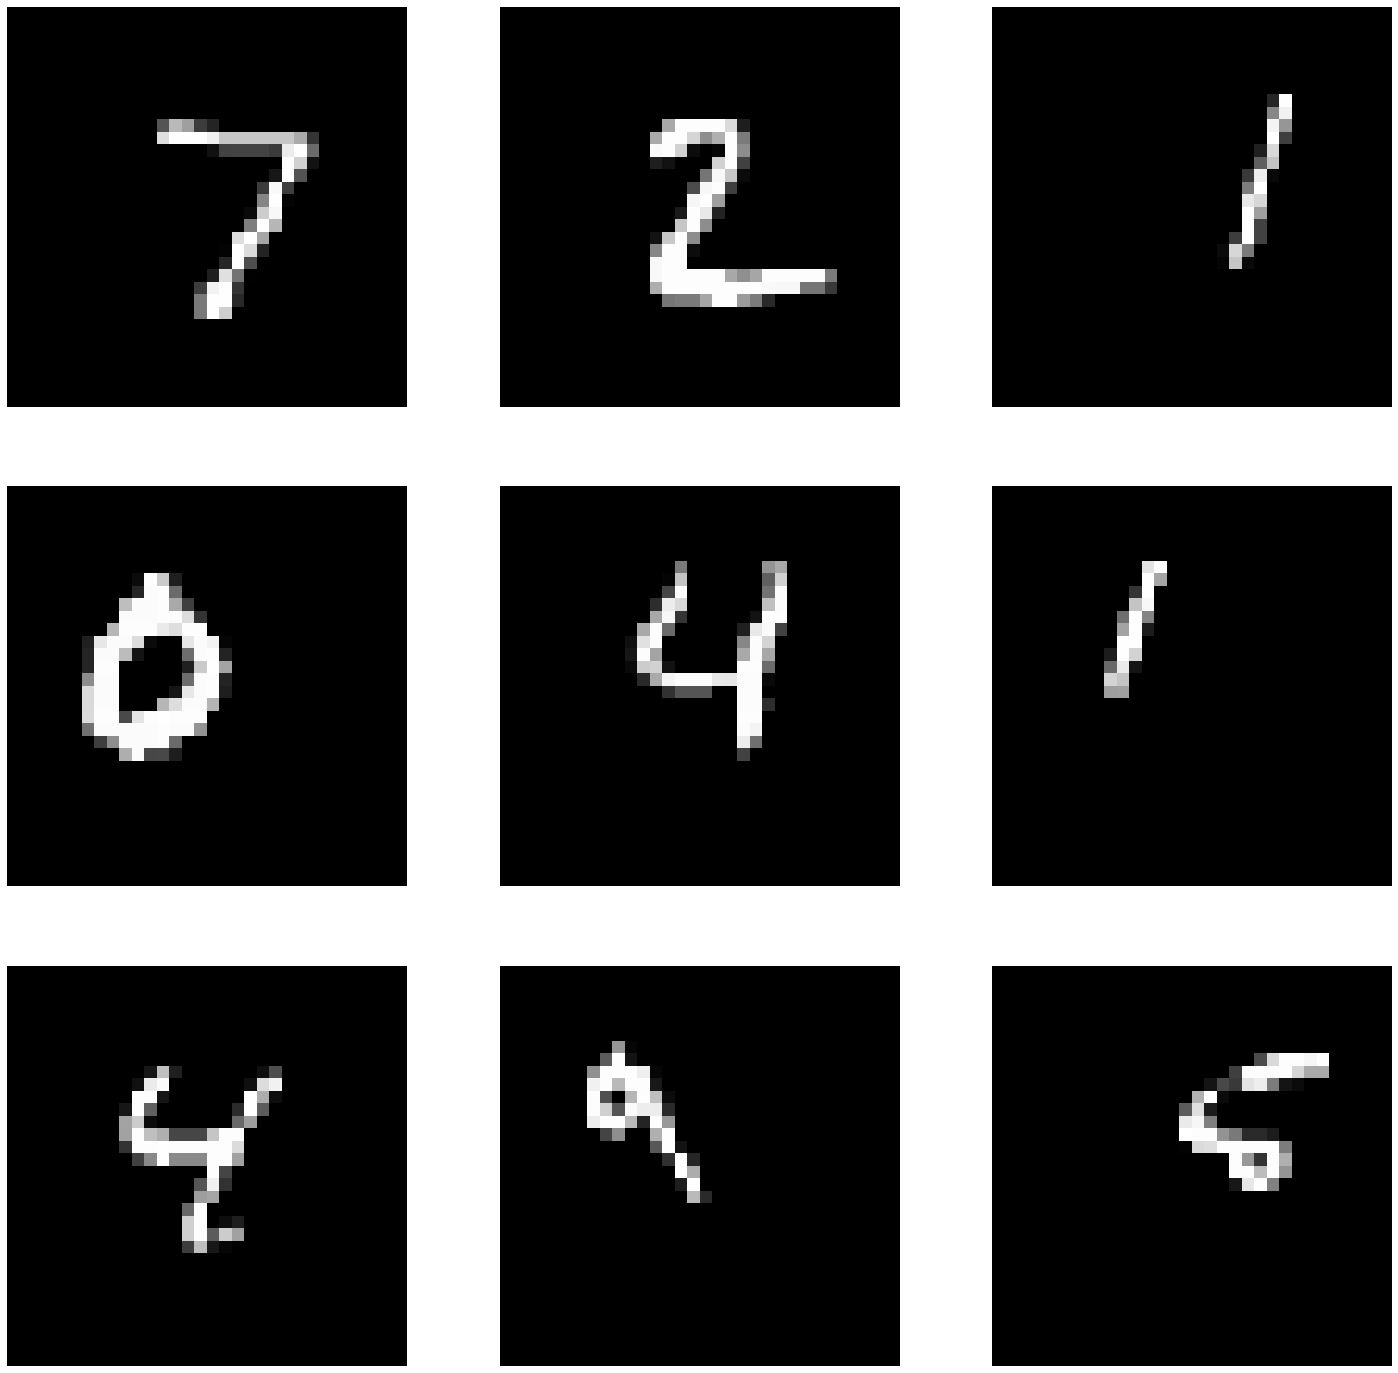

In [7]:
desiredOutputs = model_with_def.layers[0].output
newModel = Model(model_with_def.inputs, desiredOutputs)

plt.figure(figsize=(25,25))
for i,image in enumerate(X_test[:9]): 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(newModel.predict(np.expand_dims(X_test[i],axis=0))))
    plt.axis("off")


In [8]:
y_pred_model_with_def=[np.argmax(pred) for pred in model_with_def.predict(X_test)]
y_true=[np.argmax(y) for y in y_test]
classification_model_with_def=classification_report(y_true, y_pred_model_with_def)
print(classification_model_with_def)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.96      0.97      1135
           2       0.91      0.97      0.94      1032
           3       0.97      0.94      0.95      1010
           4       0.96      0.97      0.96       982
           5       0.98      0.95      0.96       892
           6       0.95      0.94      0.94       958
           7       0.93      0.92      0.93      1028
           8       0.98      0.89      0.93       974
           9       0.87      0.95      0.91      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



## 3. Useful functions

Let's define the peformances metrics

In [9]:
def DOC (x_adv_list,x_list): #degree of change
    N=len(x_adv_list)
    sum=0
    for i in range (N):        
        sum+=100*np.linalg.norm(np.reshape(x_adv_list[i] - x_list[i], -1),ord=1)/np.linalg.norm(np.reshape(x_list[i], -1),ord=1)
    return(sum/N)

def succes_rate (success_list):
    success=len([i for i in success_list if i==True])
    total=len(success_list)
    return(success/total)

##  4. Defense against black box attacks

#### Model with defense

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


Adversarial image at step 0. L2 error 8043.803611628032 and class label 8.


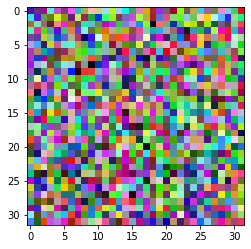

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


Adversarial image at step 1. L2 error 8035.890428488414 and class label 2.


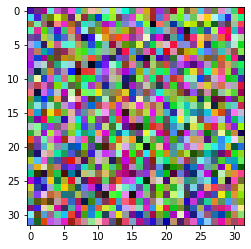

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


Adversarial image at step 2. L2 error 7993.5703259452675 and class label 1.


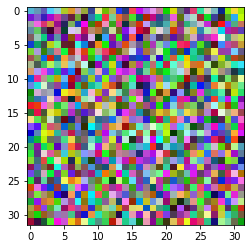

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


Adversarial image at step 3. L2 error 7985.602633321337 and class label 2.


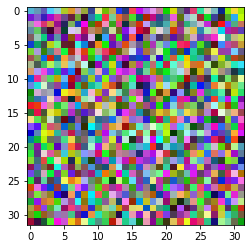

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.86s/it]


Adversarial image at step 4. L2 error 7977.493832745252 and class label 8.


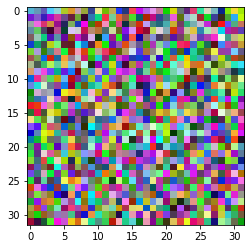

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


Adversarial image at step 5. L2 error 7965.461605410812 and class label 8.


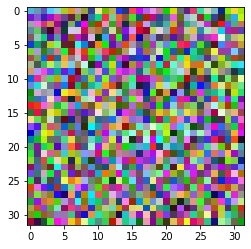

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.84s/it]


Adversarial image at step 6. L2 error 7961.83295138615 and class label 7.


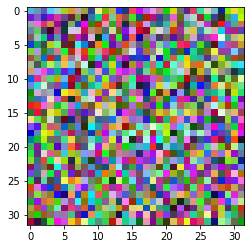

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  6.00s/it]


Adversarial image at step 7. L2 error 7958.2465877161285 and class label 8.


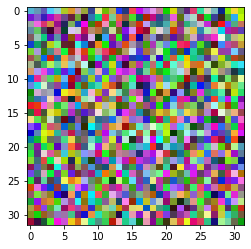

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.84s/it]


Adversarial image at step 8. L2 error 7954.706662024402 and class label 8.


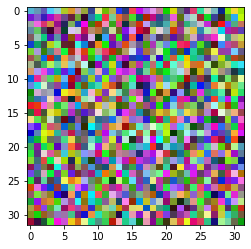

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.83s/it]


Adversarial image at step 9. L2 error 7949.38174522064 and class label 7.


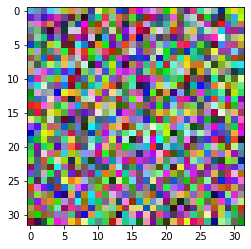

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.33s/it]


Adversarial image at step 10. L2 error 7944.055633265151 and class label 8.


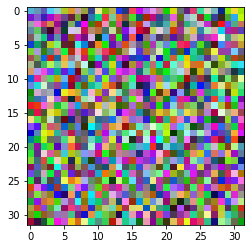

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


Adversarial image at step 11. L2 error 7938.657638766134 and class label 8.


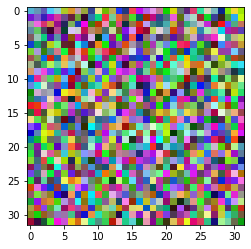

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.14s/it]


Adversarial image at step 12. L2 error 7935.099293054527 and class label 8.


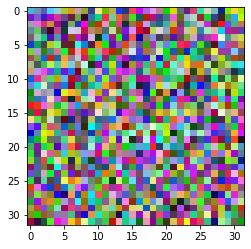

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.31s/it]


Adversarial image at step 13. L2 error 7929.751410271367 and class label 8.


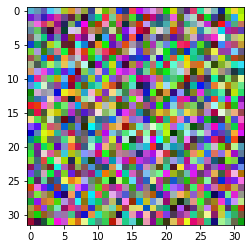

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.86s/it]


Adversarial image at step 14. L2 error 7921.662788521563 and class label 2.


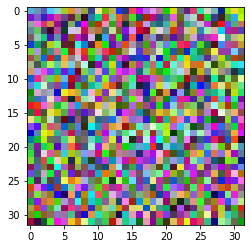

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.79s/it]


Adversarial image at step 15. L2 error 7951.733118717669 and class label 8.


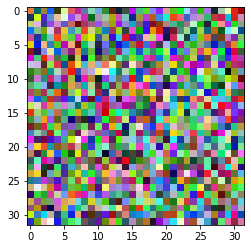

Boundary attack: 100%|██████████| 1/1 [00:09<00:00,  9.83s/it]


Adversarial image at step 16. L2 error 7881.937416461603 and class label 7.


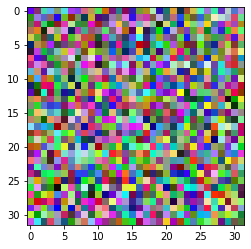

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


Adversarial image at step 17. L2 error 7881.974155359951 and class label 8.


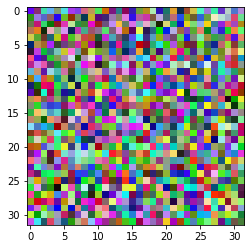

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


Adversarial image at step 18. L2 error 7882.24415605228 and class label 8.


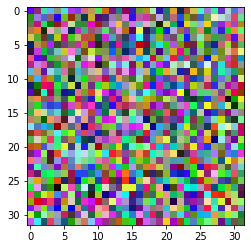

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


Adversarial image at step 19. L2 error 7881.77770713886 and class label 8.


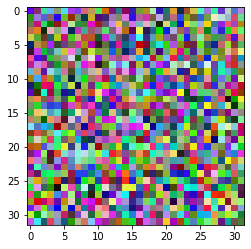

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.31s/it]


Adversarial image at step 20. L2 error 7917.784380504157 and class label 8.


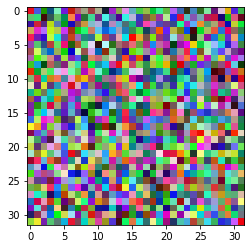

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.85s/it]


Adversarial image at step 21. L2 error 7917.902521078476 and class label 8.


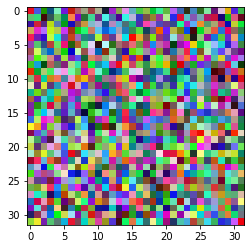

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.25s/it]


Adversarial image at step 22. L2 error 7917.912098328926 and class label 8.


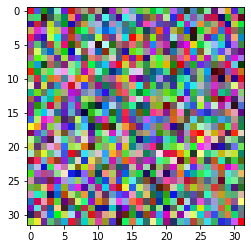

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.84s/it]


Adversarial image at step 23. L2 error 7917.860013997446 and class label 2.


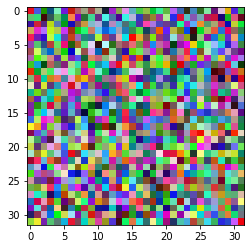

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.25s/it]


Adversarial image at step 24. L2 error 7917.946712968514 and class label 0.


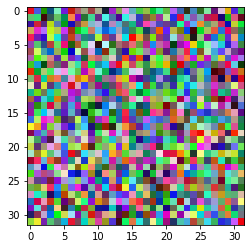

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.82s/it]


Adversarial image at step 25. L2 error 7917.855411919252 and class label 8.


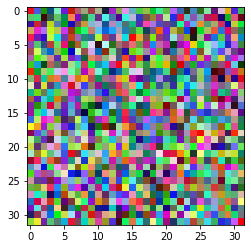

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.16s/it]


Adversarial image at step 26. L2 error 7917.888596767762 and class label 8.


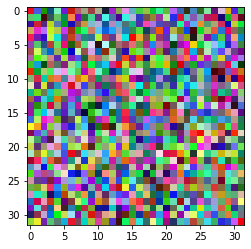

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.46s/it]


Adversarial image at step 27. L2 error 7917.898878227919 and class label 7.


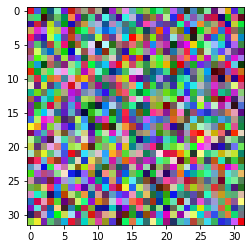

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.97s/it]


Adversarial image at step 28. L2 error 8049.659015023587 and class label 8.


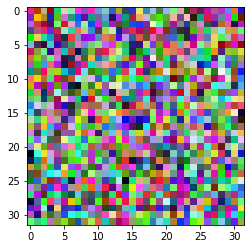

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.95s/it]


Adversarial image at step 29. L2 error 8049.587104197618 and class label 8.


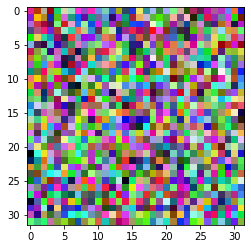

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.30s/it]


Adversarial image at step 30. L2 error 8049.196735557373 and class label 8.


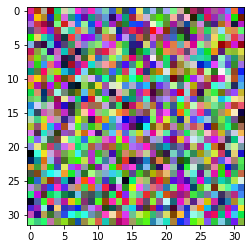

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


Adversarial image at step 31. L2 error 8049.660773698146 and class label 8.


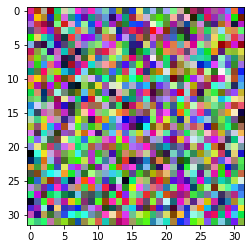

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


Adversarial image at step 32. L2 error 8049.294602727954 and class label 8.


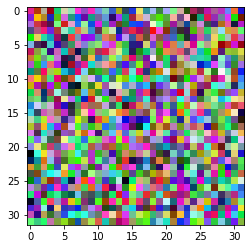

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.85s/it]


Adversarial image at step 33. L2 error 8049.19168771816 and class label 8.


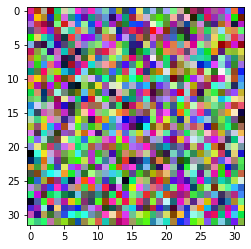

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.45s/it]


Adversarial image at step 34. L2 error 8048.846291637023 and class label 8.


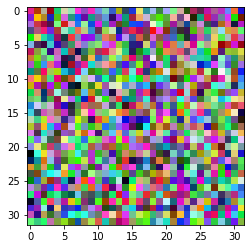

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.84s/it]


Adversarial image at step 35. L2 error 8048.525126356854 and class label 8.


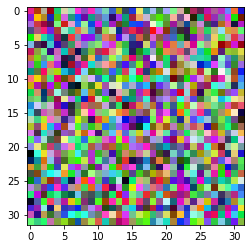

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.31s/it]


Adversarial image at step 36. L2 error 8048.657409255173 and class label 8.


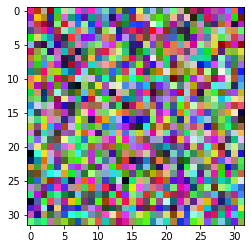

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.19s/it]


Adversarial image at step 37. L2 error 8048.564314154659 and class label 8.


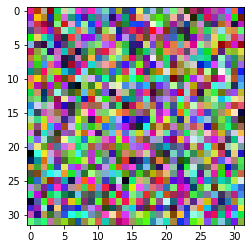

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.79s/it]


Adversarial image at step 38. L2 error 8047.891808718312 and class label 8.


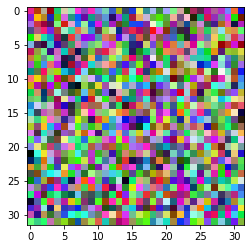

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.16s/it]


Adversarial image at step 39. L2 error 8045.030469530163 and class label 8.


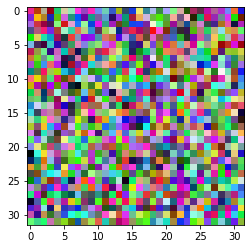

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.01s/it]


Adversarial image at step 40. L2 error 8039.726119119752 and class label 8.


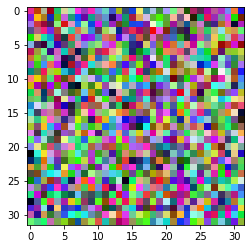

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.32s/it]


Adversarial image at step 41. L2 error 7967.320585886646 and class label 2.


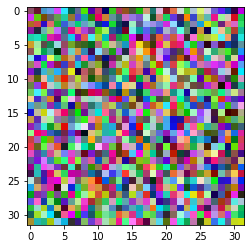

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.84s/it]


Adversarial image at step 42. L2 error 7962.69927554279 and class label 8.


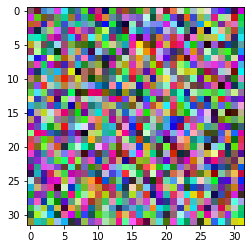

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.32s/it]


Adversarial image at step 43. L2 error 7954.912894899364 and class label 8.


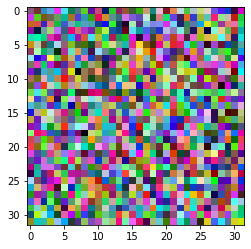

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  5.00s/it]


Adversarial image at step 44. L2 error 7898.132829472446 and class label 0.


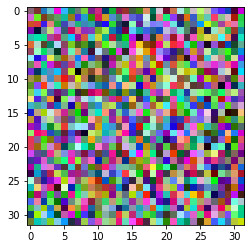

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.49s/it]


Adversarial image at step 45. L2 error 7842.685579473298 and class label 8.


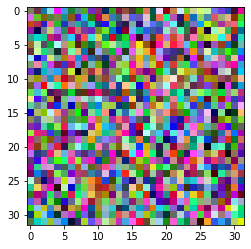

Boundary attack: 100%|██████████| 1/1 [00:14<00:00, 14.51s/it]


Adversarial image at step 46. L2 error 7740.246121644481 and class label 8.


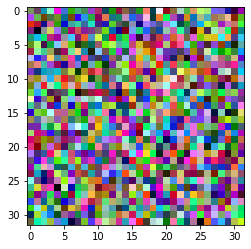

Boundary attack: 100%|██████████| 1/1 [00:09<00:00,  9.35s/it]


Adversarial image at step 47. L2 error 7707.222392049864 and class label 8.


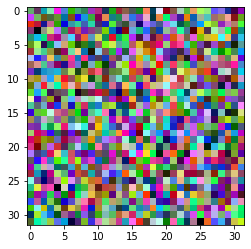

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.99s/it]


Adversarial image at step 48. L2 error 7696.075318945523 and class label 8.


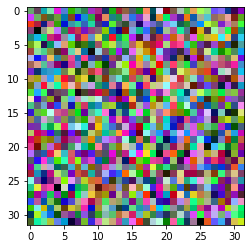

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]


Adversarial image at step 49. L2 error 7682.172768877921 and class label 8.


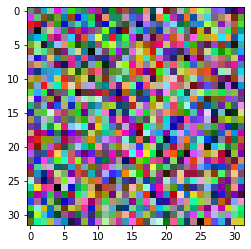

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it]


Adversarial image at step 50. L2 error 7669.20848239904 and class label 8.


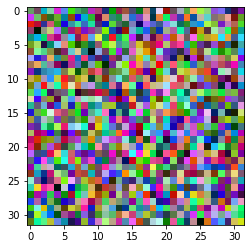

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


Adversarial image at step 51. L2 error 7662.128237488328 and class label 1.


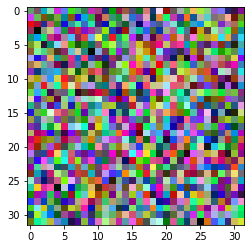

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.96s/it]


Adversarial image at step 52. L2 error 7654.696055703603 and class label 8.


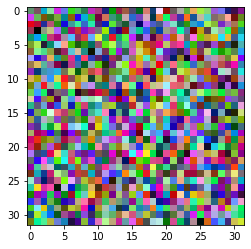

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


Adversarial image at step 53. L2 error 7646.552980619471 and class label 2.


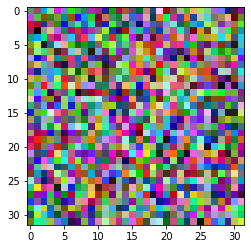

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.52s/it]


Adversarial image at step 54. L2 error 7638.794557785004 and class label 8.


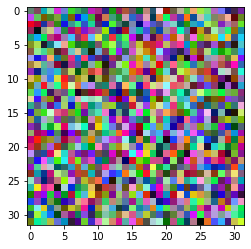

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.50s/it]


Adversarial image at step 55. L2 error 7627.99644163762 and class label 3.


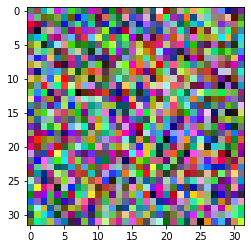

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.13s/it]


Adversarial image at step 56. L2 error 7612.734424924626 and class label 8.


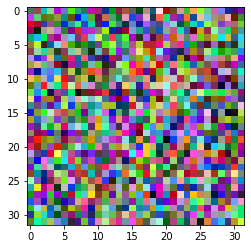

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]


Adversarial image at step 57. L2 error 7561.197488551184 and class label 8.


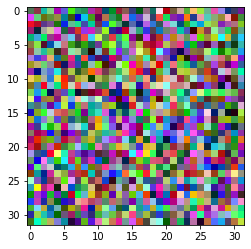

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


Adversarial image at step 58. L2 error 7527.686947349748 and class label 8.


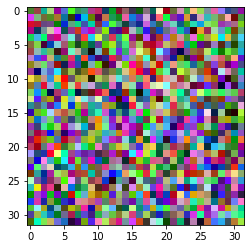

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


Adversarial image at step 59. L2 error 7925.100334326198 and class label 1.


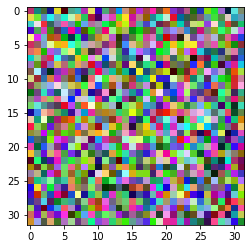

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


Adversarial image at step 60. L2 error 7911.849795784363 and class label 3.


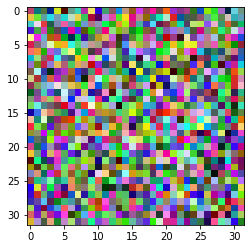

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  5.00s/it]


Adversarial image at step 61. L2 error 7900.1052004394605 and class label 8.


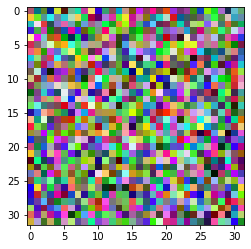

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


Adversarial image at step 62. L2 error 7857.701050972415 and class label 2.


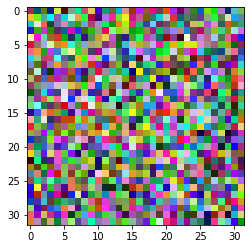

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.33s/it]


Adversarial image at step 63. L2 error 7813.534442614154 and class label 3.


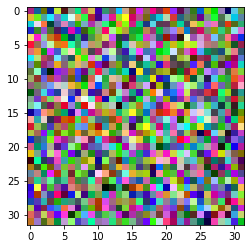

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


Adversarial image at step 64. L2 error 7764.412643055472 and class label 3.


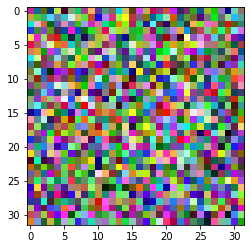

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.15s/it]


Adversarial image at step 65. L2 error 7665.1362610342385 and class label 8.


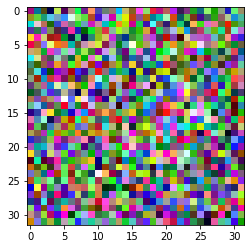

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.64s/it]


Adversarial image at step 66. L2 error 7576.310033699983 and class label 8.


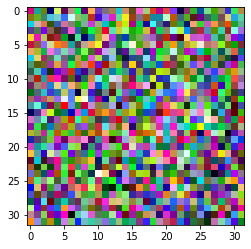

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it]


Adversarial image at step 67. L2 error 7434.379696735549 and class label 8.


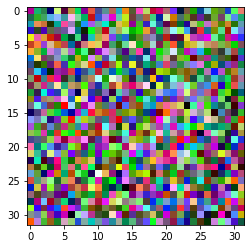

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


Adversarial image at step 68. L2 error 7311.968078841509 and class label 2.


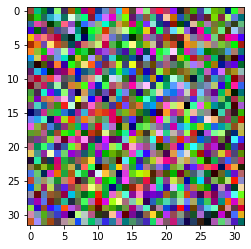

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.36s/it]


Adversarial image at step 69. L2 error 7221.777644910459 and class label 8.


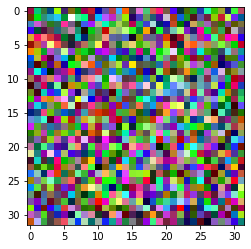

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


Adversarial image at step 70. L2 error 7082.803705549157 and class label 2.


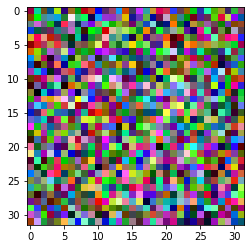

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


Adversarial image at step 71. L2 error 6994.311583885997 and class label 8.


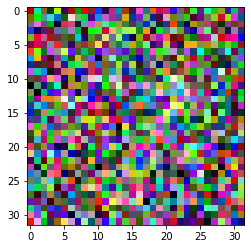

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]


Adversarial image at step 72. L2 error 6882.521815580362 and class label 2.


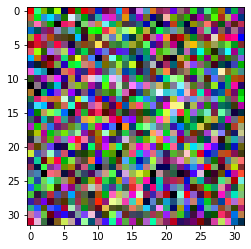

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.84s/it]


Adversarial image at step 73. L2 error 6747.997835318376 and class label 7.


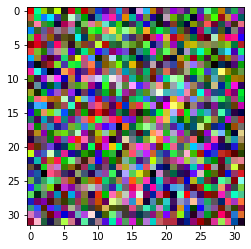

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]


Adversarial image at step 74. L2 error 6658.011291392648 and class label 7.


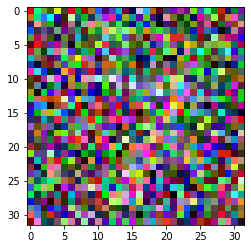

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


Adversarial image at step 75. L2 error 6560.2061948910905 and class label 7.


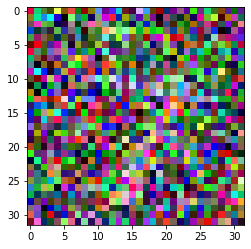

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


Adversarial image at step 76. L2 error 6472.949116124948 and class label 8.


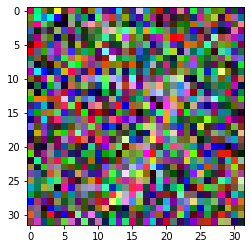

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


Adversarial image at step 77. L2 error 6439.741190647468 and class label 8.


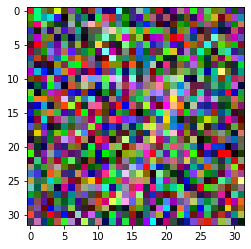

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


Adversarial image at step 78. L2 error 7895.88735552846 and class label 2.


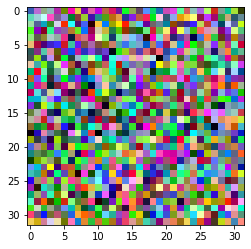

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.50s/it]


Adversarial image at step 79. L2 error 7748.007647278666 and class label 2.


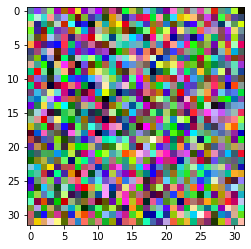

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.33s/it]


Adversarial image at step 80. L2 error 7810.585134464581 and class label 7.


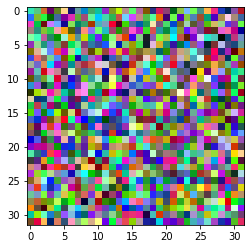

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.34s/it]


Adversarial image at step 81. L2 error 7721.210783216584 and class label 8.


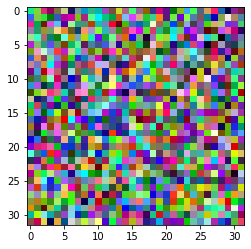

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.84s/it]


Adversarial image at step 82. L2 error 7618.838766339883 and class label 8.


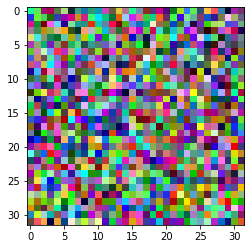

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it]


Adversarial image at step 83. L2 error 7521.013639115258 and class label 7.


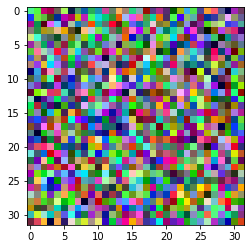

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


Adversarial image at step 84. L2 error 7454.413331143129 and class label 8.


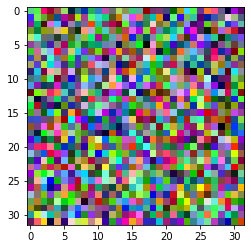

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


Adversarial image at step 85. L2 error 7913.373710213547 and class label 7.


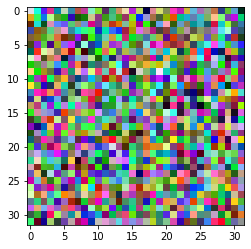

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


Adversarial image at step 86. L2 error 7843.251843257466 and class label 3.


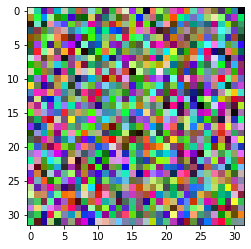

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.17s/it]


Adversarial image at step 87. L2 error 7788.86808247866 and class label 2.


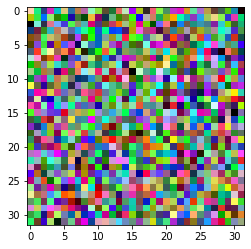

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


Adversarial image at step 88. L2 error 7672.845279339466 and class label 7.


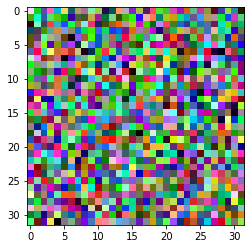

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.54s/it]


Adversarial image at step 89. L2 error 7601.410104265301 and class label 8.


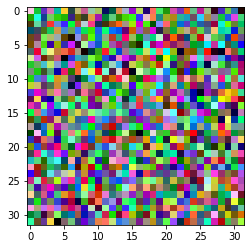

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.85s/it]


Adversarial image at step 90. L2 error 8000.168662666906 and class label 8.


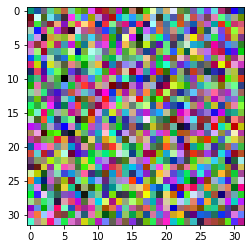

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.45s/it]


Adversarial image at step 91. L2 error 7938.271113353855 and class label 8.


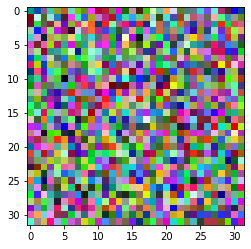

Boundary attack: 100%|██████████| 1/1 [00:10<00:00, 10.43s/it]


Adversarial image at step 92. L2 error 7917.207731615457 and class label 8.


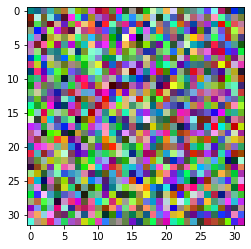

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


Adversarial image at step 93. L2 error 7897.867218068016 and class label 8.


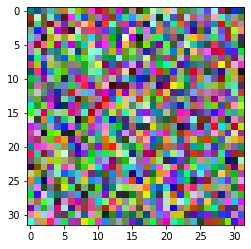

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.20s/it]


Adversarial image at step 94. L2 error 7977.978685326368 and class label 8.


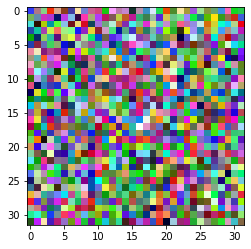

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


Adversarial image at step 95. L2 error 7925.199393806485 and class label 8.


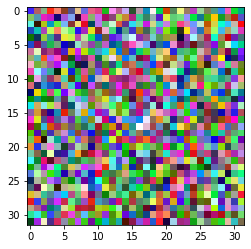

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


Adversarial image at step 96. L2 error 7891.117943040637 and class label 8.


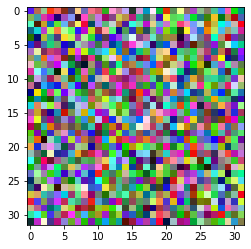

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.84s/it]


Adversarial image at step 97. L2 error 7851.821537050582 and class label 7.


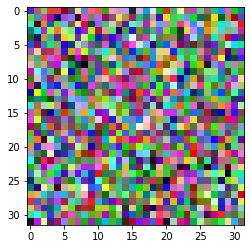

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


Adversarial image at step 98. L2 error 7822.050998904173 and class label 2.


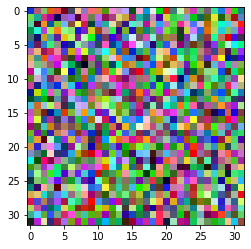

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


Adversarial image at step 99. L2 error 7786.659397455976 and class label 8.


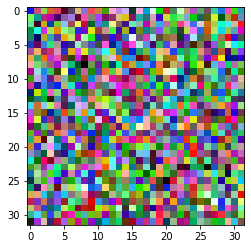

In [12]:
classifier = TensorFlowV2Classifier(model=model_with_def, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
degree_of_change_def={}
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.001)
iter_step =1
image_list_def=[]
target=X_test[0]
x_adv = None
for i in range(100):
    x_adv = attack.generate(x=np.array([target]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype('int64'))
    image_list_def.append(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    degree_of_change_def[i * iter_step]=DOC([x_adv[0]],[target])
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break




#### Model without  defense

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


Adversarial image at step 0. L2 error 8001.680958864235 and class label 1.


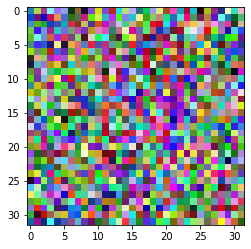

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]


Adversarial image at step 1. L2 error 7921.538422091537 and class label 1.


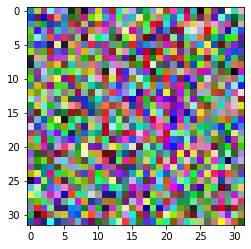

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.38s/it]


Adversarial image at step 2. L2 error 7802.543092783651 and class label 1.


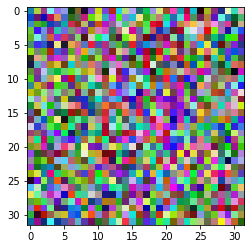

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]


Adversarial image at step 3. L2 error 7627.455750488902 and class label 1.


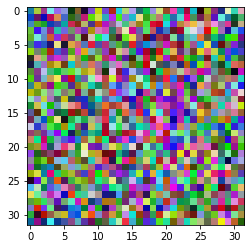

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.34s/it]


Adversarial image at step 4. L2 error 7370.735848988872 and class label 1.


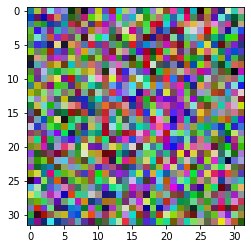

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.36s/it]


Adversarial image at step 5. L2 error 6998.366694048048 and class label 1.


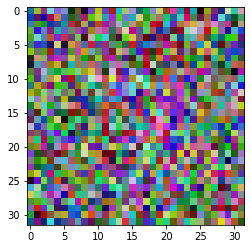

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.34s/it]


Adversarial image at step 6. L2 error 6468.696760224394 and class label 1.


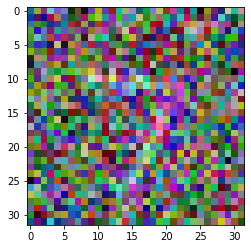

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.38s/it]


Adversarial image at step 7. L2 error 5734.056022690502 and class label 1.


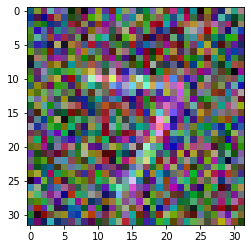

Boundary attack: 100%|██████████| 1/1 [00:09<00:00,  9.55s/it]


Adversarial image at step 8. L2 error 5082.374599734326 and class label 1.


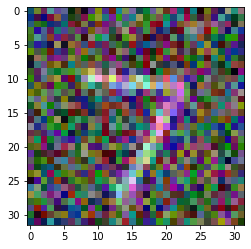

Boundary attack: 100%|██████████| 1/1 [00:22<00:00, 22.19s/it]


Adversarial image at step 9. L2 error 4967.5820973239 and class label 1.


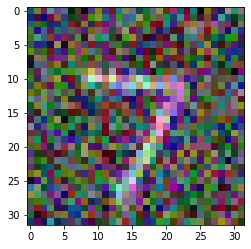

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.25s/it]


Adversarial image at step 10. L2 error 4892.4543613095175 and class label 1.


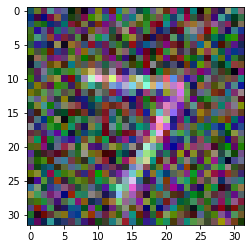

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.41s/it]


Adversarial image at step 11. L2 error 4847.16578570817 and class label 1.


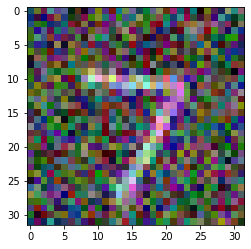

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.91s/it]


Adversarial image at step 12. L2 error 4775.369808032573 and class label 1.


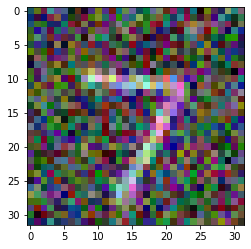

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.93s/it]


Adversarial image at step 13. L2 error 4699.068332609911 and class label 1.


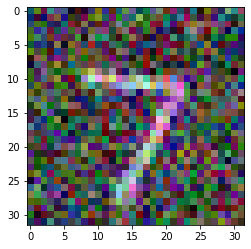

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.60s/it]


Adversarial image at step 14. L2 error 4583.356642807103 and class label 1.


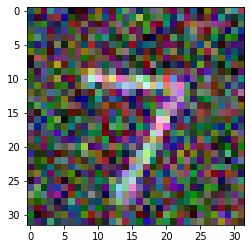

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]


Adversarial image at step 15. L2 error 4417.998674831638 and class label 1.


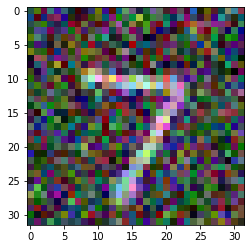

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.63s/it]


Adversarial image at step 16. L2 error 4205.32151317462 and class label 1.


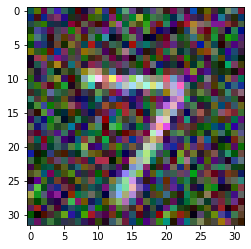

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.77s/it]


Adversarial image at step 17. L2 error 3882.2923347171695 and class label 1.


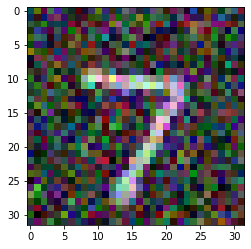

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.11s/it]


Adversarial image at step 18. L2 error 3675.612940060456 and class label 1.


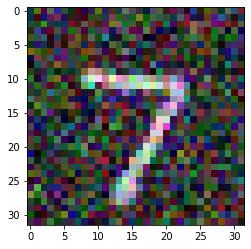

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.59s/it]


Adversarial image at step 19. L2 error 3626.407539338832 and class label 1.


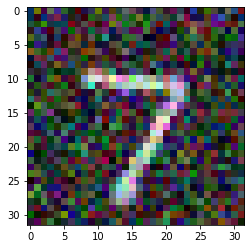

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Adversarial image at step 20. L2 error 3568.304715200323 and class label 1.


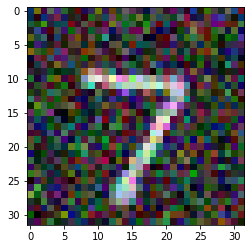

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.77s/it]


Adversarial image at step 21. L2 error 3514.7861513311004 and class label 1.


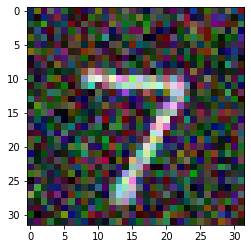

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.08s/it]


Adversarial image at step 22. L2 error 3485.217702662653 and class label 1.


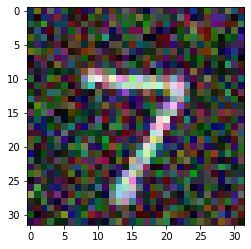

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


Adversarial image at step 23. L2 error 3438.660931284262 and class label 1.


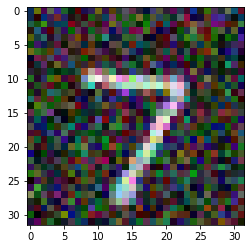

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it]


Adversarial image at step 24. L2 error 3363.3333973006756 and class label 1.


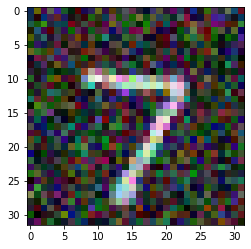

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.56s/it]


Adversarial image at step 25. L2 error 3306.181575660679 and class label 1.


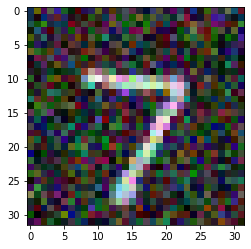

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.12s/it]


Adversarial image at step 26. L2 error 3227.913725882172 and class label 1.


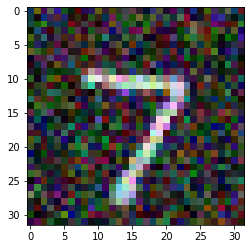

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


Adversarial image at step 27. L2 error 3156.5522714696317 and class label 1.


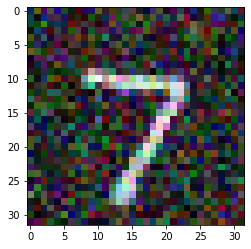

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.94s/it]


Adversarial image at step 28. L2 error 3082.2530620743955 and class label 1.


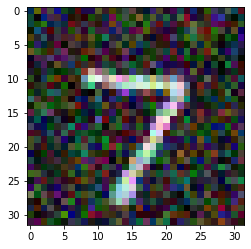

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


Adversarial image at step 29. L2 error 3066.843337408454 and class label 1.


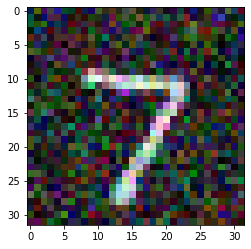

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.32s/it]


Adversarial image at step 30. L2 error 3057.6290665958345 and class label 1.


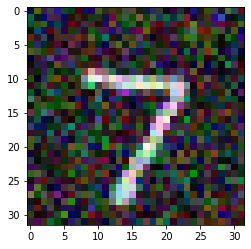

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Adversarial image at step 31. L2 error 3044.3297992553007 and class label 1.


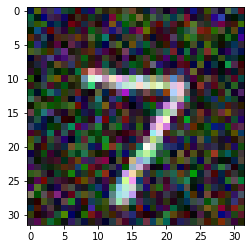

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.61s/it]


Adversarial image at step 32. L2 error 3021.138435860238 and class label 1.


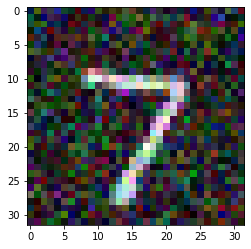

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.94s/it]


Adversarial image at step 33. L2 error 2999.1554194159953 and class label 1.


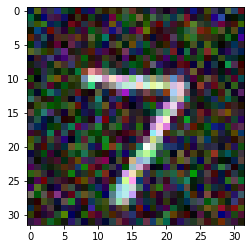

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Adversarial image at step 34. L2 error 2967.7972959271015 and class label 1.


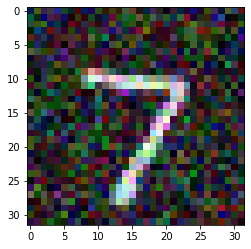

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Adversarial image at step 35. L2 error 2952.9906003700225 and class label 1.


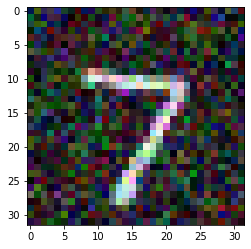

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


Adversarial image at step 36. L2 error 2932.3069933664865 and class label 1.


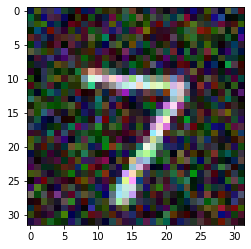

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


Adversarial image at step 37. L2 error 2912.9141067773903 and class label 1.


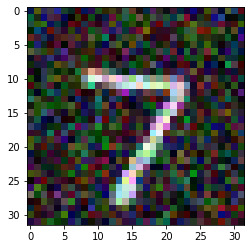

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.46s/it]


Adversarial image at step 38. L2 error 2881.61251324532 and class label 1.


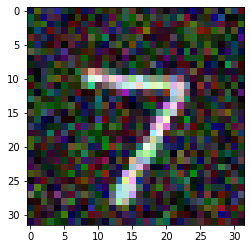

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


Adversarial image at step 39. L2 error 2859.8046967351543 and class label 1.


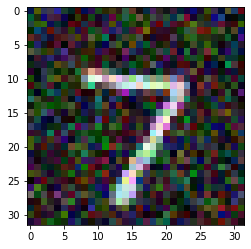

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Adversarial image at step 40. L2 error 2840.6959730492736 and class label 1.


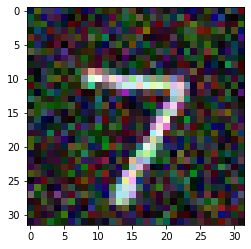

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.33s/it]


Adversarial image at step 41. L2 error 2818.384326715107 and class label 1.


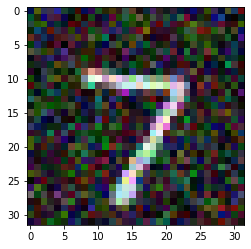

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


Adversarial image at step 42. L2 error 2791.084209426463 and class label 1.


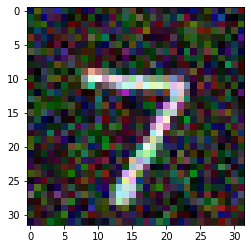

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.30s/it]


Adversarial image at step 43. L2 error 2763.9312798720107 and class label 1.


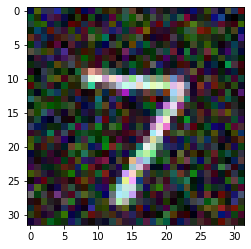

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.96s/it]


Adversarial image at step 44. L2 error 2736.507187246628 and class label 1.


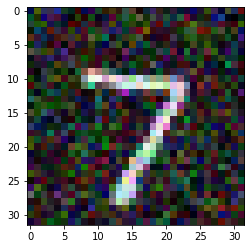

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Adversarial image at step 45. L2 error 2715.126144877938 and class label 1.


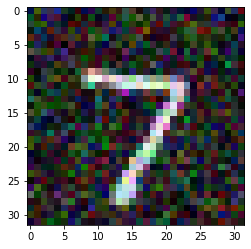

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


Adversarial image at step 46. L2 error 2697.855759509398 and class label 1.


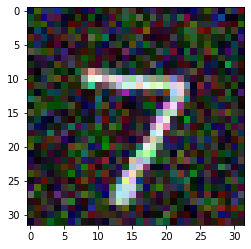

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


Adversarial image at step 47. L2 error 2678.7615051949856 and class label 1.


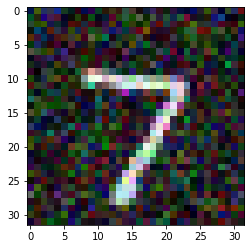

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Adversarial image at step 48. L2 error 2664.7678947945287 and class label 1.


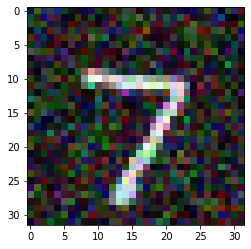

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.78s/it]


Adversarial image at step 49. L2 error 2639.8691465734278 and class label 1.


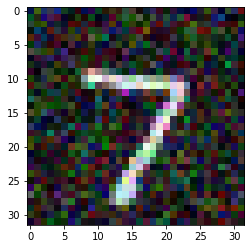

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.03s/it]


Adversarial image at step 50. L2 error 2629.5296419473307 and class label 1.


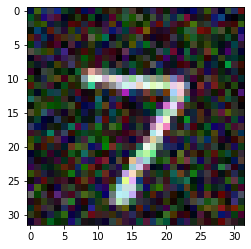

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


Adversarial image at step 51. L2 error 2616.8503112477965 and class label 1.


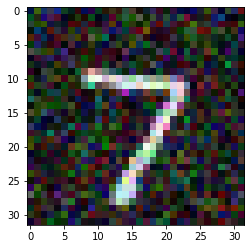

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it]


Adversarial image at step 52. L2 error 2603.668541548343 and class label 1.


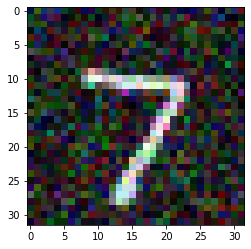

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.46s/it]


Adversarial image at step 53. L2 error 2588.5036769546955 and class label 1.


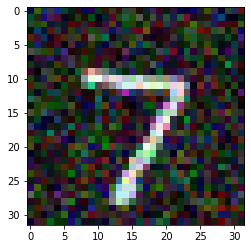

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


Adversarial image at step 54. L2 error 2572.016428684346 and class label 1.


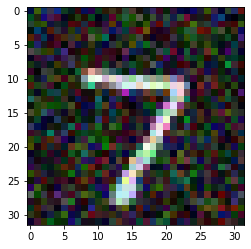

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.78s/it]


Adversarial image at step 55. L2 error 2559.346200030944 and class label 1.


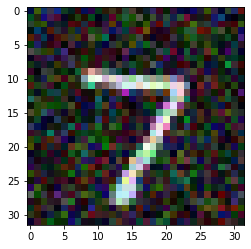

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


Adversarial image at step 56. L2 error 2548.9352311842945 and class label 1.


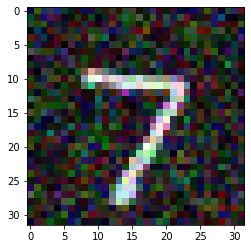

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


Adversarial image at step 57. L2 error 2538.447826331907 and class label 1.


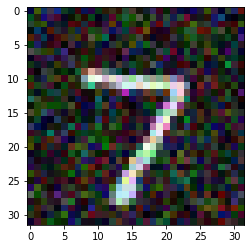

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.08s/it]


Adversarial image at step 58. L2 error 2528.6518744023247 and class label 1.


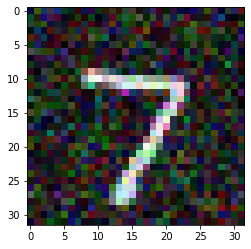

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


Adversarial image at step 59. L2 error 2516.445244250919 and class label 1.


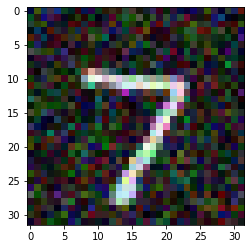

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.78s/it]


Adversarial image at step 60. L2 error 2498.7048017890033 and class label 1.


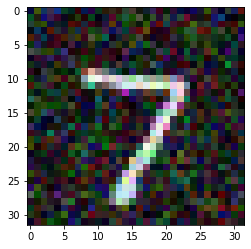

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it]


Adversarial image at step 61. L2 error 2481.974563664615 and class label 1.


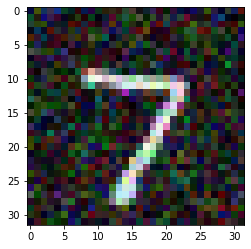

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


Adversarial image at step 62. L2 error 2464.133155407799 and class label 1.


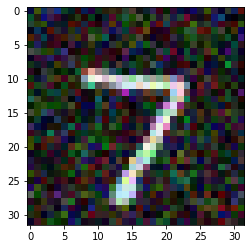

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


Adversarial image at step 63. L2 error 2449.748196257762 and class label 1.


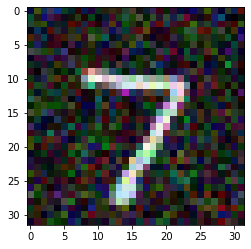

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


Adversarial image at step 64. L2 error 2428.7914328794227 and class label 1.


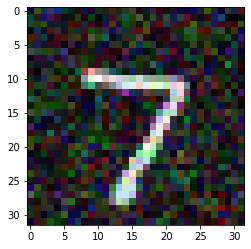

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.46s/it]


Adversarial image at step 65. L2 error 2411.7782004362994 and class label 1.


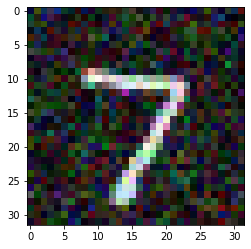

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.28s/it]


Adversarial image at step 66. L2 error 2396.7043200712815 and class label 1.


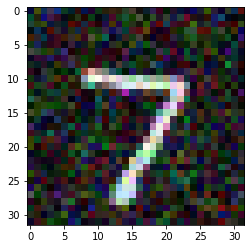

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


Adversarial image at step 67. L2 error 2375.1037908266326 and class label 1.


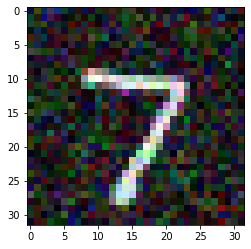

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


Adversarial image at step 68. L2 error 2352.895944705022 and class label 1.


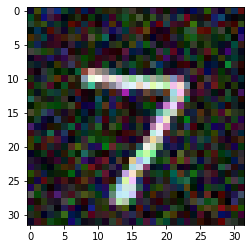

Boundary attack: 100%|██████████| 1/1 [00:08<00:00,  8.75s/it]


Adversarial image at step 69. L2 error 2341.997556335406 and class label 1.


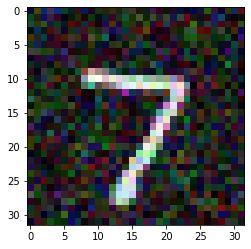

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


Adversarial image at step 70. L2 error 2329.9040782418365 and class label 1.


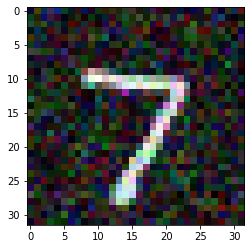

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


Adversarial image at step 71. L2 error 2318.8392585141983 and class label 1.


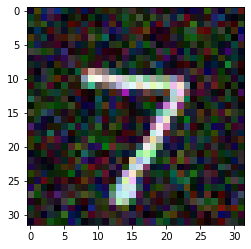

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.77s/it]


Adversarial image at step 72. L2 error 2306.3993706415895 and class label 1.


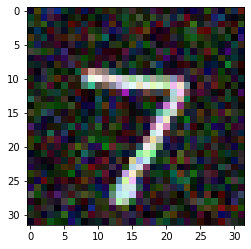

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.09s/it]


Adversarial image at step 73. L2 error 2290.8955778894947 and class label 1.


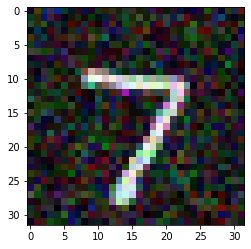

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


Adversarial image at step 74. L2 error 2275.9127930238624 and class label 1.


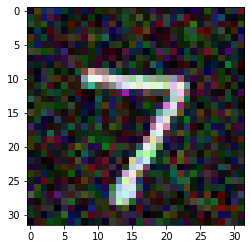

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.46s/it]


Adversarial image at step 75. L2 error 2270.105140442519 and class label 1.


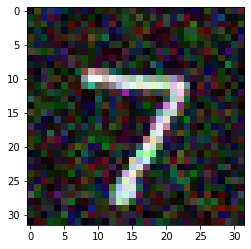

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


Adversarial image at step 76. L2 error 2263.6250006263454 and class label 1.


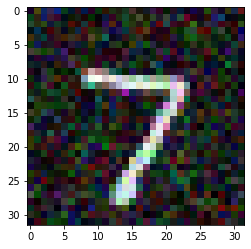

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.57s/it]


Adversarial image at step 77. L2 error 2255.481964950255 and class label 1.


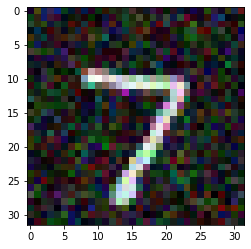

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


Adversarial image at step 78. L2 error 2247.6476522480193 and class label 1.


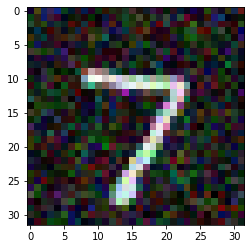

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Adversarial image at step 79. L2 error 2233.5987145198324 and class label 1.


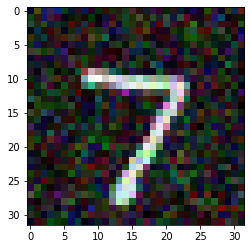

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.46s/it]


Adversarial image at step 80. L2 error 2216.6463089776244 and class label 1.


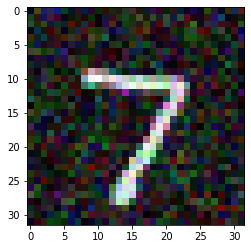

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.63s/it]


Adversarial image at step 81. L2 error 2205.271834498383 and class label 1.


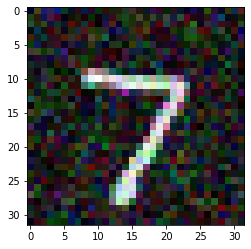

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.25s/it]


Adversarial image at step 82. L2 error 2195.607683504705 and class label 1.


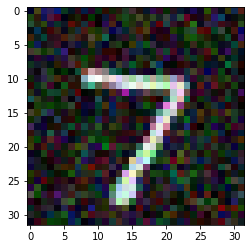

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


Adversarial image at step 83. L2 error 2185.7945701949025 and class label 1.


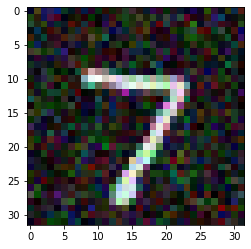

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.65s/it]


Adversarial image at step 84. L2 error 2176.1378875658393 and class label 1.


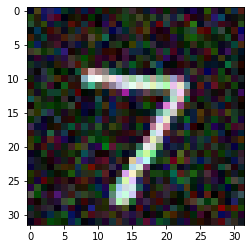

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it]


Adversarial image at step 85. L2 error 2166.0035622618193 and class label 1.


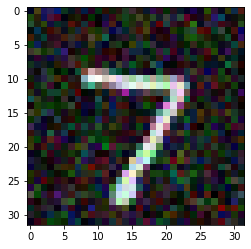

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.62s/it]


Adversarial image at step 86. L2 error 2157.1690827067955 and class label 1.


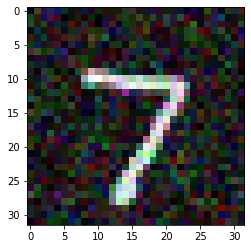

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.76s/it]


Adversarial image at step 87. L2 error 2148.6382149914302 and class label 1.


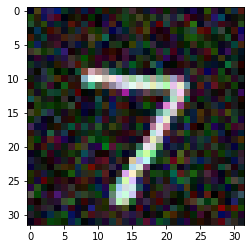

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.94s/it]


Adversarial image at step 88. L2 error 2137.6682061651004 and class label 1.


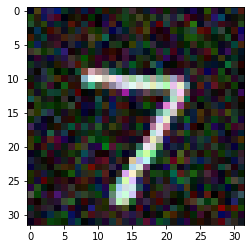

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


Adversarial image at step 89. L2 error 2121.487460803002 and class label 1.


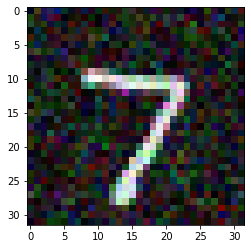

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.63s/it]


Adversarial image at step 90. L2 error 2112.6332628938144 and class label 1.


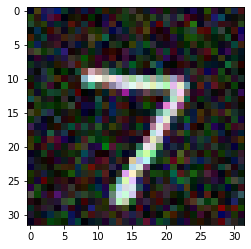

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.93s/it]


Adversarial image at step 91. L2 error 2106.0532314398192 and class label 1.


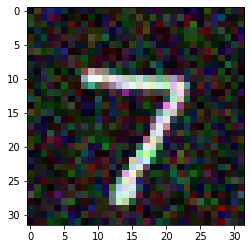

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  4.00s/it]


Adversarial image at step 92. L2 error 2099.598384840509 and class label 1.


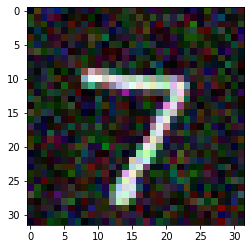

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.96s/it]


Adversarial image at step 93. L2 error 2089.614419383411 and class label 1.


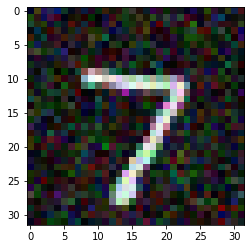

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


Adversarial image at step 94. L2 error 2080.045653418717 and class label 1.


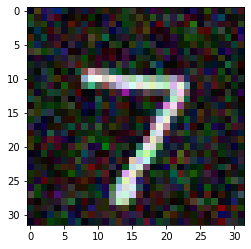

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Adversarial image at step 95. L2 error 2069.233645276879 and class label 1.


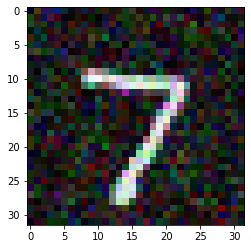

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it]


Adversarial image at step 96. L2 error 2046.8566303417747 and class label 1.


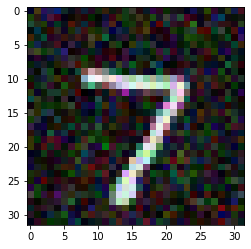

Boundary attack: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


Adversarial image at step 97. L2 error 2031.7377351755351 and class label 1.


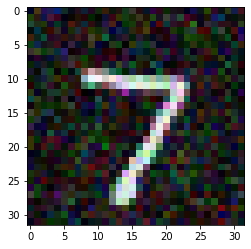

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]


Adversarial image at step 98. L2 error 2021.3182776780404 and class label 1.


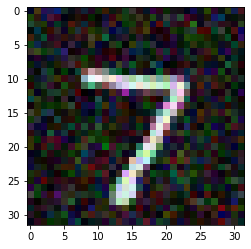

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


Adversarial image at step 99. L2 error 2014.233386178422 and class label 1.


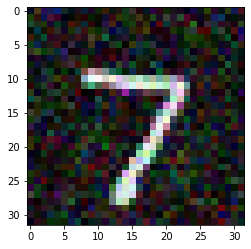

In [17]:
model_without_def=load_model('/media/hdd1/benchmark_adversarial_attacks/effnet_model.h5')

classifier = TensorFlowV2Classifier(model=model_without_def, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
degree_of_change={}
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.01)
iter_step =1
image_list=[]
target=X_test[0]
x_adv = None
for i in range(100):
    x_adv = attack.generate(x=np.array([target]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype(np.uint))
    image_list.append(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    degree_of_change[i * iter_step]=DOC([x_adv[0]],[target])
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break


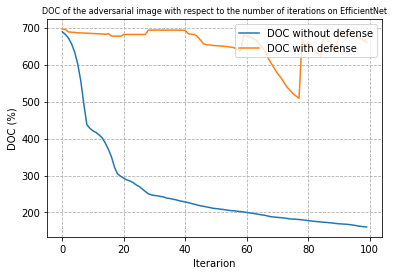

In [20]:
plt.plot(list(degree_of_change.keys()),list(degree_of_change.values()),label='DOC without defense')
plt.plot(list(degree_of_change_def.keys()),list(degree_of_change_def.values()),label='DOC with defense')
plt.grid(True,which="both", linestyle='--')
plt.title('DOC of the adversarial image with respect to the number of iterations on EfficientNet', fontsize=8)
plt.xlabel('Iterarion')
plt.ylabel('DOC (%)')

plt.legend(loc='upper right')
plt.show()

##### Save images as .gif

In [19]:
# for i,image in enumerate(image_list_def):
      
#     im=np.array(tf.image.resize(image.astype('uint8'), [200,200], method='nearest', preserve_aspect_ratio=True))
#     im = Image.fromarray(im.astype('uint8'), 'RGB')
#     image_list_def[i]=im

# from PIL import Image
# image_list_def[0].save('attack_with_defense.gif',
#                save_all=True, append_images=image_list_def[1:], optimize=False, duration=40, loop=0)

AttributeError: 'Image' object has no attribute 'astype'

In [21]:
# for i,image in enumerate(image_list):
      
#     im=np.array(tf.image.resize(image.astype('uint8'), [200,200], method='nearest', preserve_aspect_ratio=True))
#     im = Image.fromarray(im.astype('uint8'), 'RGB')
#     image_list[i]=im

# from PIL import Image
# image_list[0].save('attack_without_defense.gif',
#                save_all=True, append_images=image_list[1:], optimize=False, duration=40, loop=0)

##  5. Defense against white box attacks

In [10]:
def attack_performances_computer(model_to_fool,attack, image_list, labels,epsilon):
    if len(labels[0])>1:
        labels=list(map(np.argmax,labels))
    success=[]
    adv_list=[]
    attack_value=[]
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_fool,image,label,epsilons=epsilon)
        success.append(bool(is_adv[0][0]))
        adv_list.append(np.array(clipped[0][0]))
        prediction=model_with_def.predict(np.expand_dims(clipped[0][0],axis=0))           
        attack_value+=[np.argmax(prediction)]
    DOC_attack=DOC(adv_list,image_list)
    SR_attack=succes_rate(success)
    return(DOC_attack,SR_attack)


In [11]:
def attack_runner(model_to_fool,image_list, labels_list, epislons_list):   
    
    
    attack_FGSM=LinfFastGradientAttack()
    
    if len(labels_list[0])<=5:
        labels_list=list(map(np.argmax,labels_list))

    SR_FGSM_dic={}  


    for epsilon in epislons_list:
        print('======'+'epislon: '+str(epsilon)+'======')
        DOC_FGSM,SR_FGSM=attack_performances_computer(model_to_fool,attack_FGSM, image_list, labels_list,[epsilon])
              
        SR_FGSM_dic[DOC_FGSM]=SR_FGSM
        
    return(SR_FGSM_dic)

In [12]:
model_to_fool = TensorFlowModel(model_with_def , bounds=(0, 255))
SR_FGSM_dic_with_defense=attack_runner(model_to_fool,X_test[:100], y_test[:100], [0.1,0.5,1,5,7,10,15,20,30,50])
with open('data/perfs_global_Mnist_FGSM_with_defense', 'wb') as f:
    pickle.Pickler(f).dump(SR_FGSM_dic_with_defense)
    

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.001======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.01======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 100======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1000======


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


In [13]:
model_without_def=load_model('/media/hdd1/benchmark_adversarial_attacks/effnet_model_Mnist.h5')
model_to_fool = TensorFlowModel(model_without_def , bounds=(0, 255))
SR_FGSM_dic_without_defense=attack_runner(model_to_fool,X_test[:100], y_test[:100], [0.001,0.01,0.1,1,10,100,1000])


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.001======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.01======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 100======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1000======


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


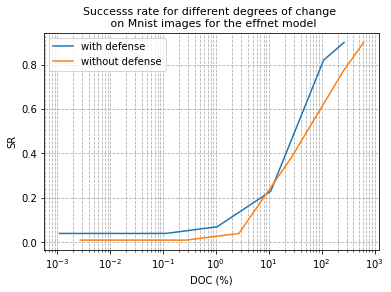

In [14]:
plt.plot(list(SR_FGSM_dic_with_defense.keys()),list(SR_FGSM_dic_with_defense.values()),label='with defense')
plt.plot(list(SR_FGSM_dic_without_defense.keys()),list(SR_FGSM_dic_without_defense.values()),label='without defense')
plt.xscale('log')
plt.grid(True,which="both", linestyle='--')
plt.title('Successs rate for different degrees of change \n on Mnist images for the effnet model',fontsize=11)
plt.xlabel('DOC (%)')
plt.ylabel('SR')
plt.legend(loc='upper left')
